In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from scipy.optimize import leastsq
from scipy.fftpack import rfft, irfft, fftfreq
import scipy
from scipy.signal import find_peaks
%matplotlib inline

## Reading Data

In [3]:
df = pd.read_csv('QuantumDataAdded.csv', header = 0)
df = df[df.columns[1:9]]
df["Landau Resistance"].iloc[0] = 0
df = df.astype(float)
df.head()
df.dtypes

Magnetic Field (T)          float64
Rxx (kOhm)                  float64
Rxy (kOhm)                  float64
Inverse of B (T)            float64
Landau Levels               float64
Landau Resistance           float64
dRxx/dB                     float64
$\frac{d^2R_{xx}}{dB^2}$    float64
dtype: object

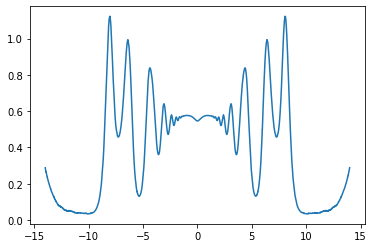

In [4]:
plt.plot(df["Magnetic Field (T)"] ,df["Rxx (kOhm)"])

## Low Pass Filter then FFT on Original Data

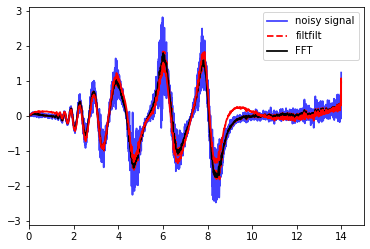

In [5]:
from scipy import signal
import matplotlib.pyplot as plt
from scipy.signal import lfilter, lfilter_zi, filtfilt, butter,sosfilt

# FILTFILT 
t = df["Magnetic Field (T)"].iloc[0:27979]
xn = df["dRxx/dB"].iloc[0:27979]

# Create an order 3 lowpass butterworth filter.
b, a = butter(3, 0.05)

# Apply the filter to xn.  Use lfilter_zi to choose the initial condition
# of the filter.
zi = lfilter_zi(b, a)
z, _ = lfilter(b, a, xn, zi=zi*xn[0])

# Apply the filter again, to have a result filtered at an order
 #the same as filtfilt.
z2, _ = lfilter(b, a, z, zi=zi*z[0])


# Use filtfilt to apply the filter.
y = filtfilt(b, a, xn)


# FAST FOURIER TRANSFORM

time   = df["Magnetic Field (T)"].iloc[0:27979]
signal = y

W = fftfreq(signal.size, d=time[1]-time[0])
f_signal = rfft(signal)

# If our original signal time was in seconds, this is now in Hz    
cut_f_signal = f_signal.copy()
cut_f_signal[(W<0.6)] = 0

cut_signal = irfft(cut_f_signal)


#Make the plot.
plt.plot(t, xn, 'b', linewidth=1.75, alpha=0.75)
plt.plot(t, z, 'r--', linewidth=1.75)
#plt.plot(t, z2, 'r', linewidth=1.75)
plt.plot(t, y, 'k', linewidth=1.75)
plt.xlim(0,15)
plt.plot(t, cut_signal, 'r', linewidth=1.75)
plt.legend(('noisy signal',
        'filtfilt', 'FFT'),
        loc='best')



## Another Low Pass Filter of Order 10

(0, 1)

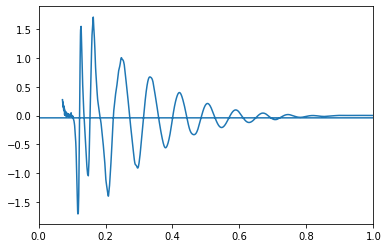

In [6]:
cut_signal2 = y
sos = butter(10, 10, 'lp', fs=1000, output='sos')
filtered = sosfilt(sos, cut_signal2)

#plt.plot(time,y1)
plt.plot(df["Inverse of B (T)"].iloc[0:27979],filtered)
plt.xlim(0,1)

## Find Extrema

[-0.26178010471165564, -0.21696680407873115, -0.16914749661692194, -0.12026458208053176, 0.11768859597522263, 0.16337199803983346, 0.20842017507339936, 0.24734108335455665, 0.29603315571428346, 0.33255736614670217, 0.3792188092542639, 0.4205214465953805, 0.4640371229717648, 0.504540867812546, 0.5464480874343122, 0.628535512259854]


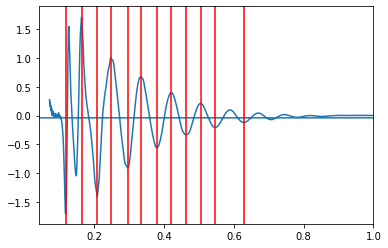

In [7]:
#plt.plot(df["Magnetic Field (T)"].iloc[0:27979], df["dRxx/dB"].iloc[0:27979])
plt.plot(df["Inverse of B (T)"].iloc[0:27979],filtered)
plt.xlim(0.040,1)

#derivY = []
#for i in range(0,len(y)-1):
   # derivY.append((y[i+1] - y[i])/(df["Magnetic Field (T)"].iloc[i+1] -df["Magnetic Field (T)"].iloc[i]))


y2 = []
for j in filtered:
    y2.append(abs(j))
    
peaks, _ = find_peaks(y2, prominence = 0.1)
peaks1, _ = find_peaks(y2, prominence = 0.8, distance = 700)


xEx = []
for k in peaks:
    if df["Inverse of B (T)"].iloc[k] > 0.275:
        xEx.append(df["Inverse of B (T)"].iloc[k])
        plt.axvline(x = (df["Inverse of B (T)"].iloc[k]), color = "r")
for l in peaks1:
    if df["Inverse of B (T)"].iloc[l] < 0.275:
        xEx.append(df["Inverse of B (T)"].iloc[l])
        plt.axvline(x = (df["Inverse of B (T)"].iloc[l]), color = "r")   

xEx = list(set(xEx))
xEx.sort()
print(xEx)

## Check Landau Levels using $\frac{h}{e^2}$

[0.08253549026080508, 0.1314233144959305, 0.16957775139888745, 0.23250406882091407, 0.26737967914397887, 0.32404406999288454, 0.3645643456061711, 0.4158004157993057, 0.4587155963288979, 0.5083884087425582, 0.5534034310992049, 0.6009615384590712, 0.6472491909356217]
12
2


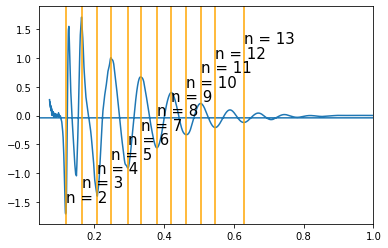

In [9]:
incr = 0
xvals = []
fig, ax3 = plt.subplots()

ax3.plot(df["Inverse of B (T)"].iloc[0:27979], filtered)
ax3.set_xlim(0.040,1)
for l in range(1,15):
    resistance = df["Landau Resistance"].iloc[l]
    for j in range(0, len(df["Rxy (kOhm)"])):
        if abs(resistance - df["Rxy (kOhm)"].iloc[j]) <= 0.005:
            xvals.append(-1 / df["Magnetic Field (T)"].iloc[j])
            inverseB = -1 / df["Magnetic Field (T)"].iloc[j]
            text = "n = " + str(l)
            '''
            if len(xvals) == 1:
                landau = ax3.axvline(x = inverseB, color = "r", linestyle = ':', label = "Landau Levels")
                #ax3.annotate(text,xy=(inverseB, -3 - incr), fontsize = 15)
            else:
                landau = ax3.axvline(x = inverseB, color = "r", linestyle = ':')
                #ax3.annotate(text,xy=(inverseB, -3 - incr), fontsize = 15)
            incr -= 0.3
            '''
            break
print(xvals)       
y2 = []
for j in filtered:
    y2.append(abs(j))
    
peaks, _ = find_peaks(y2, prominence = 0.1)
peaks1, _ = find_peaks(y2, prominence = 0.8, distance = 700)

'''
for k in peaks:
    if df["Inverse of B (T)"].iloc[k] > 0.275:
        plt.axvline(x = (df["Inverse of B (T)"].iloc[k]), color = "orange")
for l in peaks1:
    if df["Inverse of B (T)"].iloc[l] < 0.275:
        plt.axvline(x = (df["Inverse of B (T)"].iloc[l]), color = "orange")  
'''
xEx = [item for item in xEx if item >= 0]
print(len(xEx))
taken = []
minDist = 999999
for j in xvals:
    dist = abs(xEx[0]- j)
    taken.append(dist)
        
minLevel = taken.index(min(taken)) + 1
print(minLevel)

incr = 0
p = 0
for i in range(minLevel, minLevel + len(xEx)):
    text = "n = " + str(i)
    ax3.axvline(x = (xEx[p]), color = "orange")  
    ax3.annotate(text,xy=(xEx[p], -1.5 - incr), fontsize = 15)
    incr -= 0.25
    p += 1


#ax3.legend()

## ON Rxx vs. B
### MIGHT HAVE TO TRY USING linear separator

In [10]:
from scipy import constants
from scipy.signal import argrelextrema

def plotRxxGraph(x,y,rxy):
# x = Inverse of B
# y = filtered
# rxy = Rxy
    fig, ax3 = plt.subplots()
    ax3.plot(x, y, color = "blue", label = r"$R_{xx}$")
    ax3.set_xlim(2,9)
    ax3.set_ylabel(r"$R_{xx}$")
    ax3.set_xlabel(r"$B$")
    ax3.set_title(r"$R_{xx}$" + " vs. " + "$B$")
    
    mean = np.mean(y)
    
    y2 = []
    mean = np.mean(y)
    subtractor = y[len(y) // 2]
    y2 = np.array(y) - subtractor
    
    #ax3.axhline(subtractor, color = "red")
    #ax3.axhline(mean, color = "orange")
    inverty2 = []
    for i in y2:
        inverty2.append(abs(i))
        
    peaks, _ = find_peaks(inverty2, prominence = 0.05,distance = 200)
    
    xEx = []
    for i in peaks:
        xEx.append(x[i])
        
    xEx = list(set(xEx))


    xEx = [item for item in xEx if item >= 0]
    xEx.sort()
    incr = 0
    
    xvals = []
    
    xLOL = [item for item in x if item >= 0]
    b = []
    for i in xLOL:
        b.append(i)

    #ax3.plot(x, y)
    closestDist = []
    
    rxy2 = []
    for i in range(len(b)):
        if  b[i] >=0:
            rxy2.append(rxy[i])
            
    minDist = 0
    for l in range(1, 15):
        resistance = constants.h / (l * constants.e * constants.e * 1000)
        for j in range(len(rxy2)):
            #if abs(resistance - rxy[j]) <= minDist:
            closestDist.append(abs(resistance - rxy2[j]))
        minDist = min(closestDist)
        closestIndex = closestDist.index(minDist)
        closestDist = []
        xvals.append(b[closestIndex])
    
    print(xEx)
    print(xvals)
    taken = []
    levels = []
    done = False
    for x in xEx:
        for j in xvals:
            dist = abs(x-j)
            taken.append(dist)
        level = taken.index(min(taken)) + 1
        while not done:
            if level in levels:
                level += 1
            else:
                done = True
        done = False
        levels.append(level)
        taken = []
    print(levels)

    incr = 0
    p = 0
    for i in range(len(levels)):
        if i == 0:
            text = "n = " + str(levels[i])
            ax3.axvline(x=(xEx[p]), color="orange", label = "Landau Levels")
            ax3.annotate(text, xy=(xEx[p], 0 - incr), fontsize=15)
        else:
            text = "n = " + str(levels[i])
            ax3.axvline(x=(xEx[p]), color="orange")
            ax3.annotate(text, xy=(xEx[p], 0 - incr), fontsize=15)
        incr -= 0.1
        p += 1
    
    labelled = False
    for j in xvals:
        if not labelled: 
            ax3.axvline(x=j, color="red", ls = ":",label = "Landau Levels")
            labelled =True
        else:
            ax3.axvline(x=j, color="red", ls = ":")
    ax3.legend(bbox_to_anchor=(1.10, 0.55))
    
    dfg0 = df[df["Magnetic Field (T)"] >= 0]
    plt.plot(dfg0["Magnetic Field (T)"].tolist(), dfg0["Rxy (kOhm)"].tolist())
    plt.xlabel('B')
    plt.ylabel('Rxy')

    print(xEx)
    xInv = []
    for i in xEx:
        xInv.append(i)
    incr = 0
    p = 0


[2.6929999999907555, 3.0809999999905404, 3.576999999990265, 4.373999999989822, 5.3749999999892655, 6.389999999988705, 7.272999999988217, 8.058999999987778, 10.013999999986694]
[0.0009999999922456482, 1.8869999999912004, 6.385999999988707, 8.097999999987758, 9.690999999986873, 10.256999999986563, 10.905999999986202, 11.25199999998601, 11.586999999985824, 11.817999999985695, 12.025999999985581, 12.188999999985493, 12.32999999998541, 12.448999999985347]
[2, 3, 4, 5, 6, 7, 8, 9, 10]
[2.6929999999907555, 3.0809999999905404, 3.576999999990265, 4.373999999989822, 5.3749999999892655, 6.389999999988705, 7.272999999988217, 8.058999999987778, 10.013999999986694]


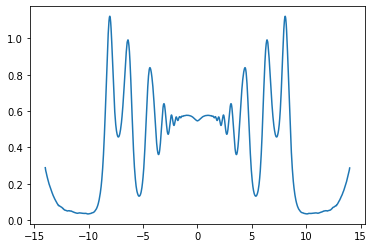

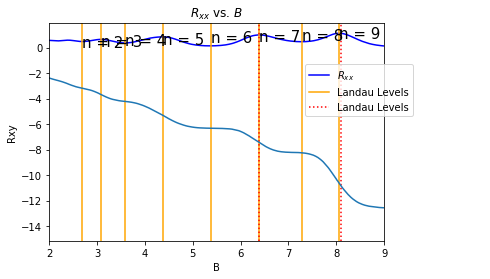

In [11]:
import landauFilter as lf
B = df["Magnetic Field (T)"].tolist()
Rxx = df["Rxx (kOhm)"].tolist()
rxy = df["Rxy (kOhm)"].tolist()
newRxx = lf.filterRxx(B,Rxx)


plt.plot(B,newRxx)
plotRxxGraph(B,newRxx,rxy)

## CHECK RXY FOR $\frac{dR_{xy}}{dB} \approx 0$

In [25]:
dfg0 = df[df["Magnetic Field (T)"] >= 0]
B = dfg0["Magnetic Field (T)"].tolist()
y = dfg0["Rxy (kOhm)"].tolist()
print(len(B))
dRxy = []
for i in range(len(B)-1):
    dRxy.append(  (y[i+1] - y[i])  / (B[i+1] - B[i]))
dRxy.append(0)
print(len(dRxy))
dfg0["dRxy/dB"] = dRxy
dfg0.head()

13989
13989


C:\Users\emu4y\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,Magnetic Field (T),Rxx (kOhm),Rxy (kOhm),Inverse of B (T),Landau Levels,Landau Resistance,dRxx/dB,$\frac{d^2R_{xx}}{dB^2}$,dRxy/dB
13991,0.001,0.545630,-0.001896,1000.000008,13991.0,0.001845,0.008658,10.841948,-1.026477
13992,0.002,0.545638,-0.002923,500.000002,13992.0,0.001845,0.019500,11.574050,-0.883401
13993,0.003,0.545658,-0.003806,333.333334,13993.0,0.001845,0.031074,9.066655,-0.887471
13994,0.004,0.545689,-0.004694,250.000000,13994.0,0.001845,0.040140,3.666487,-0.986362
13995,0.005,0.545729,-0.005680,200.000000,13995.0,0.001844,0.043807,-4.279733,-1.131281


[2.6889999999907577, 3.0809999999905404, 3.5799999999902616, 4.373999999989822, 5.3419999999892855, 6.389999999988705, 7.283999999988209, 8.056999999987783, 10.041999999986679]
[0.0009999999922456482, 1.8869999999912004, 6.385999999988707, 8.097999999987758, 9.690999999986873, 10.256999999986563, 10.905999999986202, 11.25199999998601, 11.586999999985824, 11.817999999985695, 12.025999999985581, 12.188999999985493, 12.32999999998541, 12.448999999985347]
[2, 3, 4, 5, 6, 7, 8, 9, 10]
[-1.0264772840818535, -1.2389188171039962, -1.3639589818522238, -5.013535431651977, -0.07794344896046554, -0.21592457038416643, 0.34680019994307365, -0.22701240345640594, -0.30084151782200386, -0.5249780899262003, 0.02558872448867075, -0.09685545097349127, -0.35697557475187014, -0.6637855345509662]


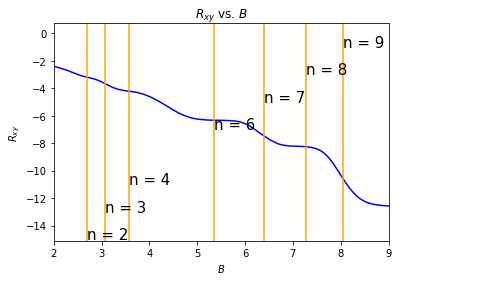

In [36]:
from scipy.ndimage import gaussian_filter1d

x = dfg0["Magnetic Field (T)"].tolist()
y = dfg0["Rxx (kOhm)"].tolist()

# x = Inverse of B
# y = filtered
# rxy = Rxy
fig, ax3 = plt.subplots()
ax3.plot(x, dfg0["Rxy (kOhm)"].tolist(), color = "blue", label = r"$R_{xy}$")
ax3.set_xlim(2,9)
ax3.set_ylabel(r"$R_{xy}$")
ax3.set_xlabel(r"$B$")
ax3.set_title(r"$R_{xy}$" + " vs. " + "$B$")
    
mean = np.mean(y)

y2 = []
mean = np.mean(y)
subtractor = y[len(y) // 2]
y2 = np.array(y) - subtractor

#ax3.axhline(subtractor, color = "red")
#ax3.axhline(mean, color = "orange")
inverty2 = []
for i in y2:
    inverty2.append(abs(i))

peaks, _ = find_peaks(inverty2, prominence = 0.05,distance = 200)

xEx = []
for i in peaks:
    xEx.append(x[i])

xEx = list(set(xEx))


xEx = [item for item in xEx if item >= 0]
xEx.sort()
incr = 0

xvals = []

xLOL = [item for item in x if item >= 0]
b = []
for i in xLOL:
    b.append(i)

#ax3.plot(x, y)
closestDist = []

rxy2 = []
for i in range(len(b)):
    if  b[i] >=0:
        rxy2.append(rxy[i])

checkRxy = []
minDist = 0
for l in range(1, 15):
    resistance = constants.h / (l * constants.e * constants.e * 1000)
    for j in range(len(rxy2)):
        #if abs(resistance - rxy[j]) <= minDist:
        closestDist.append(abs(resistance - rxy2[j]))
    minDist = min(closestDist)
    closestIndex = closestDist.index(minDist)
    closestDist = []
    checkRxy.append(dfg0["dRxy/dB"].iloc[closestIndex])
    xvals.append(b[closestIndex])

print(xEx)
print(xvals)
taken = []
levels = []
done = False
for x in xEx:
    for j in xvals:
        dist = abs(x-j)
        taken.append(dist)
    level = taken.index(min(taken)) + 1
    while not done:
        if level in levels:
            level += 1
        else:
            done = True
    done = False
    levels.append(level)
    taken = []
print(levels)

print(checkRxy)
incr = 0
p = 0
for i in range(len(levels)):
    if i == 0 and abs(checkRxy[i]) < 2:
        text = "n = " + str(levels[i])
        ax3.axvline(x=(xEx[p]), color="orange", label = "Landau Levels")
        ax3.annotate(text, xy=(xEx[p], -15 - incr), fontsize=15)
    elif abs(checkRxy[i]) < 2:
        text = "n = " + str(levels[i])
        ax3.axvline(x=(xEx[p]), color="orange")
        ax3.annotate(text, xy=(xEx[p], -15 - incr), fontsize=15)
    incr -= 2
    p += 1